# Chapter 14: Cash Flow Analysis

This chapter delves into the heart of a company's lifeblood – its cash flow. We'll utilize the Tiingo API to retrieve historical cash flow data for a chosen stock ticker. With this data, we'll analyze the components of a cash flow statement and calculate free cash flow.

**Data Extraction and Preparation**

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tiingo import TiingoClient

# --- Tiingo API Configuration ---
config = {
    'session': True,
    'api_key': 'YOUR KEY'  # Replace with your own API key
}
client = TiingoClient(config)

# --- Define the stock ticker ---
ticker = "AAPL"

# --- Fetch fundamental statement data ---
try:
    data = client.get_fundamentals_statements(
        ticker,
        startDate='2021-01-01',
        endDate='2023-12-31',
        asReported=True,
        fmt='json'
    )
    fundamentals = pd.DataFrame(data)
except Exception as e:
    print(f"Error fetching data: {e}")
    raise

# --- Filter out annual data (only keep quarterly) ---
fundamentals = fundamentals[fundamentals['quarter'] != 0].copy()

# --- Define a reusable function to extract statement data ---
def extract_statement(data, statement_type, ticker=None):
    """Extracts and normalizes specified statement data (e.g., 'cashFlow')."""
    extracted_data = []
    for _, row in data.iterrows():
        if statement_type in row.get('statementData', {}):
            for item in row['statementData'][statement_type]:
                record = item.copy()
                record.update({
                    'date': row.get('date'),
                    'quarter': row.get('quarter'),
                    'year': row.get('year'),
                    'ticker': ticker  # Provide manually since it's not in the API response
                })
                extracted_data.append(record)
    return pd.DataFrame(extracted_data)

# --- Extract cash flow statement data ---
cash_flow_df = extract_statement(fundamentals, 'cashFlow', ticker=ticker)

# --- Pivot the data for analysis ---
cash_flow_pivot = cash_flow_df.pivot(
    index='date',
    columns='dataCode',
    values='value'
).reset_index()

# --- Convert date column to datetime ---
cash_flow_pivot['date'] = pd.to_datetime(cash_flow_pivot['date'])
cash_flow_pivot = cash_flow_pivot.sort_values('date').set_index('date')

# --- Display sample raw data ---
display(cash_flow_df.head())
display(cash_flow_pivot.head())

,dataCode,value,date,quarter,year,ticker
0,depamor,2.653000e+09,2023-11-03,4,2023,AAPL
1,sbcomp,2.625000e+09,2023-11-03,4,2023,AAPL
2,freeCashFlow,1.943500e+10,2023-11-03,4,2023,AAPL
3,ncfx,0.000000e+00,2023-11-03,4,2023,AAPL
4,ncff,-2.315300e+10,2023-11-03,4,2023,AAPL


dataCode,businessAcqDisposals,capex,depamor,freeCashFlow,investmentsAcqDisposals,issrepayDebt,issrepayEquity,ncf,ncff,ncfi,ncfo,ncfx,payDiv,sbcomp
date,,,,,,,,,,,,,,
2022-04-29,-167000000.0,-2.514000e+09,2.737000e+09,2.565200e+10,-6.390000e+09,-1.751000e+09,-2.263100e+10,-9.450000e+09,-2.835100e+10,-9.265000e+09,2.816600e+10,0.0,-3.595000e+09,2.252000e+09
2022-07-29,-2000000.0,-2.102000e+09,2.805000e+09,2.079000e+10,6.953000e+09,9.710000e+08,-2.186500e+10,-3.190000e+08,-2.744500e+10,4.234000e+09,2.289200e+10,0.0,-3.811000e+09,2.243000e+09
2022-10-28,-137000000.0,-3.289000e+09,2.865000e+09,2.083800e+10,2.806000e+09,1.657000e+09,-2.442800e+10,-3.884000e+09,-2.679400e+10,-1.217000e+09,2.412700e+10,0.0,-3.703000e+09,2.278000e+09
2023-02-03,0.0,-3.787000e+09,2.916000e+09,3.021800e+10,2.483000e+09,-9.615000e+09,-1.947500e+10,-3.003000e+09,-3.556300e+10,-1.445000e+09,3.400500e+10,0.0,-3.768000e+09,2.905000e+09
2023-05-05,0.0,-2.916000e+09,2.898000e+09,2.564400e+10,5.341000e+09,-1.996000e+09,-1.959400e+10,5.155000e+09,-2.572400e+10,2.319000e+09,2.856000e+10,0.0,-3.650000e+09,2.686000e+09


## 14.1 Cash Flow Components Analysis

Key Components:
Operating Activities: Cash from core business operations

Investing Activities: Cash used for long-term assets

Financing Activities: Cash from/for financing activities

Free Cash Flow (FCF) Calculation:
FCF = Operating Cash Flow - Capital Expenditures

In [2]:
# Map data codes to human-readable column names
column_mapping = {
    'ncfo': 'netCashProvidedByOperatingActivities',
    'ncfi': 'netCashUsedForInvestingActivities',
    'ncff': 'netCashUsedProvidedByFinancingActivities',
    'capex': 'capitalExpenditures'
}

# Map and create new columns
for code, col in column_mapping.items():
    if code in cash_flow_pivot.columns:
        cash_flow_pivot[col] = cash_flow_pivot[code]

# Calculate Free Cash Flow
if 'netCashProvidedByOperatingActivities' in cash_flow_pivot.columns and 'capitalExpenditures' in cash_flow_pivot.columns:
    cash_flow_pivot['free_cash_flow'] = (
        cash_flow_pivot['netCashProvidedByOperatingActivities'] - 
        cash_flow_pivot['capitalExpenditures']
    )

# Prepare for display: reset index to include 'date' as a column
cash_flow_display = cash_flow_pivot.reset_index()

# Select columns to display
display_cols = [
    'date',
    'netCashProvidedByOperatingActivities',
    'netCashUsedForInvestingActivities',
    'netCashUsedProvidedByFinancingActivities',
    'free_cash_flow'
]

# Show the table
display(cash_flow_display[display_cols].dropna())


dataCode,date,netCashProvidedByOperatingActivities,netCashUsedForInvestingActivities,netCashUsedProvidedByFinancingActivities,free_cash_flow
0,2022-04-29,2.816600e+10,-9.265000e+09,-2.835100e+10,3.068000e+10
1,2022-07-29,2.289200e+10,4.234000e+09,-2.744500e+10,2.499400e+10
2,2022-10-28,2.412700e+10,-1.217000e+09,-2.679400e+10,2.741600e+10
3,2023-02-03,3.400500e+10,-1.445000e+09,-3.556300e+10,3.779200e+10
4,2023-05-05,2.856000e+10,2.319000e+09,-2.572400e+10,3.147600e+10
5,2023-08-04,2.638000e+10,4.370000e+08,-2.404800e+10,2.847300e+10
6,2023-11-03,2.159800e+10,2.394000e+09,-2.315300e+10,2.376100e+10


## 14.2 Visualization of Cash Flow Components

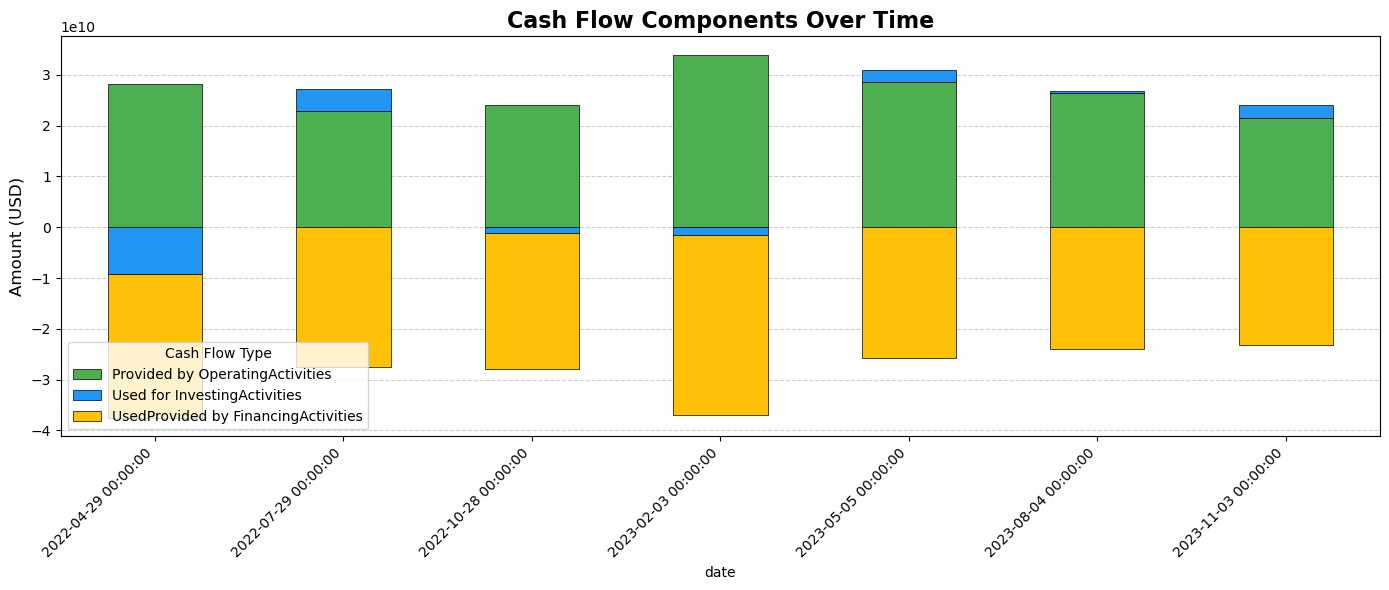

In [5]:
# Sort index just in case
cash_flow_pivot = cash_flow_pivot.sort_index()

# Define the components to plot
components = [
    'netCashProvidedByOperatingActivities',
    'netCashUsedForInvestingActivities',
    'netCashUsedProvidedByFinancingActivities'
]

# Filter out missing columns
components_present = [col for col in components if col in cash_flow_pivot.columns]

# Set up figure and axis
fig, ax = plt.subplots(figsize=(14, 6))

# Define color map
color_map = {
    'netCashProvidedByOperatingActivities': '#4CAF50',   # Green
    'netCashUsedForInvestingActivities': '#2196F3',      # Blue
    'netCashUsedProvidedByFinancingActivities': '#FFC107' # Amber
}

# Plot stacked bar chart
if components_present:
    cash_flow_pivot[components_present].plot(
        kind='bar',
        stacked=True,
        color=[color_map[c] for c in components_present],
        ax=ax,
        edgecolor='black',
        linewidth=0.5
    )
    ax.set_title('Cash Flow Components Over Time', fontsize=16, fontweight='bold')
    ax.set_ylabel('Amount (USD)', fontsize=12)
    ax.legend(
        [col.replace('netCash', '').replace('By', ' by ').replace('For', ' for ') for col in components_present],
        title='Cash Flow Type'
    )
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.set_axisbelow(True)
else:
    ax.text(0.5, 0.5, 'No cash flow components available', ha='center', va='center', fontsize=12)
    ax.axis('off')

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Layout adjustment
plt.tight_layout()
plt.show()



## 14.3 Summary
This chapter focuses on **Cash Flow Analysis**, an essential part of understanding a company’s financial health. By retrieving historical cash flow data using the Tiingo API, we can analyze a company’s cash inflows and outflows, ultimately calculating the important metric of **Free Cash Flow (FCF)**. The analysis reveals how a company generates and uses cash across its operations, investments, and financing activities.
